# Optimal Music Classification
In the first test, I wanted to observe which features performed well under the constraints of a small dense network with limited features. Here I will be Increasing the network size and features to attempt getting 80% accuacy goal without overfitting.

In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pathlib
import csv
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
#Keras
import keras

The MFCC data performed the best, which is within expectations as it is a compression of the fetures of a mel spectrogram, while the other datasets were bottlenecked at the same number of features. In short while it has the same amount of variables ,those variables are "enhanced" in the information they contain. In addition due to the baseline data coming close or outperforming the others, I would like to try and dissern if all of these are valuble. I will be using the MFCC data for this network as well as testing combinations with some of the baseline data.

In [87]:
#define mesurements
n_fft = 2048
hop_len = 512

def generate_mfcc_data(n_mfcc):
    header = 'filename zero_crossing_rate spectral_rolloff spectral_centroid spectral_bandwidth spectral_contrast rmse'
    for i in range(1, n_mfcc+1):
        header += f' mfcc{i}'
    header += ' label'
    header = header.split()
    file_n = 'mfcc_data_'+str(n_mfcc)+'.csv'
    file = open(file_n, 'w', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(header)
    genres = [name for name in os.listdir('genres') if os.path.isdir(os.path.join('genres', name)) ]
    for g in genres:
        for filename in os.listdir(f'./genres/{g}'):
            songname = f'./genres/{g}/{filename}'
            y, sr = librosa.load(songname, mono=True, duration=30)
            mfcc = librosa.feature.mfcc(y=y, sr=sr,n_mfcc=n_mfcc,n_fft=n_fft,hop_length=hop_len)
            zcr = librosa.feature.zero_crossing_rate(y)
            rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
            spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            spec_con = librosa.feature.spectral_contrast(y=y, sr=sr,n_fft=n_fft,hop_length=hop_len)
            rmse = librosa.feature.rms(y)                                             
            to_append = f'{filename} {np.mean(zcr)} {np.mean(rolloff)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(spec_con)} {np.mean(rmse)}'    
            
            for c in mfcc:
                to_append += f' {np.mean(c)}'
            to_append += f' {g}'
            file = open(file_n, 'a', newline='')
            with file:
                writer = csv.writer(file)
                writer.writerow(to_append.split())
    file.close()
generate_mfcc_data(24)

"\nn_chroma = 12\nheader = 'filename spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'\n#for i in range(1, 21):\n#    header += f' mfcc{i}'\nfor i in range(1, n_chroma+1):\n    header += f' chroma{i}'\nheader += ' label'\nheader = header.split()\n\nfile = open('data.csv', 'w', newline='')\nwith file:\n    writer = csv.writer(file)\n    writer.writerow(header)\ngenres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()\nfor g in genres:\n    for filename in os.listdir(f'./genres/{g}'):\n        songname = f'./genres/{g}/{filename}'\n        y, sr = librosa.load(songname, mono=True, duration=30)\n        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr,n_chroma=n_chroma)\n        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)\n        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)\n        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)\n        zcr = librosa.feature.zero_crossing_rate(y)\n        #mfcc = librosa.feat

In [88]:
data = pd.read_csv('mfcc_data_24.csv')
data = data.drop(['filename'],axis=1)
genre_list = data.iloc[:, -1]
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list)
scaler = StandardScaler()
x = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2) #this also shuffles

In [89]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
EPOCHS=10
H = model.fit(x_train,
              y_train,
              epochs=EPOCHS,
              batch_size=100,
              validation_data=(x_val, y_val))

Epoch 1/10
8/8 [==============================] - 0s 13ms/step - loss: 2.1376 - sparse_categorical_accuracy: 0.2575 - val_loss: 1.9027 - val_sparse_categorical_accuracy: 0.3800
Epoch 2/10
8/8 [==============================] - 0s 3ms/step - loss: 1.6920 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.4767 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/10
8/8 [==============================] - 0s 3ms/step - loss: 1.3464 - sparse_categorical_accuracy: 0.5387 - val_loss: 1.2471 - val_sparse_categorical_accuracy: 0.5650
Epoch 4/10
8/8 [==============================] - 0s 3ms/step - loss: 1.1368 - sparse_categorical_accuracy: 0.6250 - val_loss: 1.0767 - val_sparse_categorical_accuracy: 0.6300
Epoch 5/10
8/8 [==============================] - 0s 3ms/step - loss: 0.9829 - sparse_categorical_accuracy: 0.6712 - val_loss: 1.0335 - val_sparse_categorical_accuracy: 0.6100
Epoch 6/10
8/8 [==============================] - 0s 3ms/step - loss: 0.8612 - sparse_categorical_accuracy: 0.7200 - va

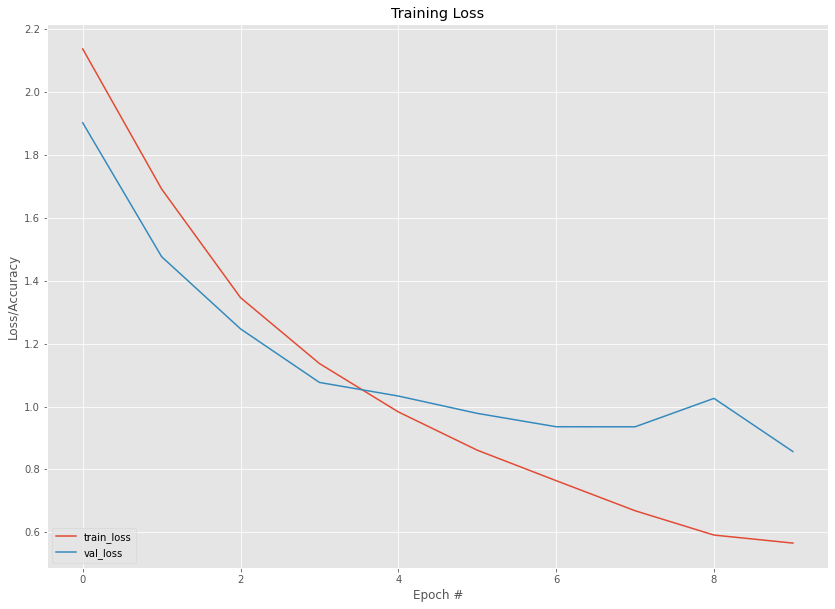

In [90]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

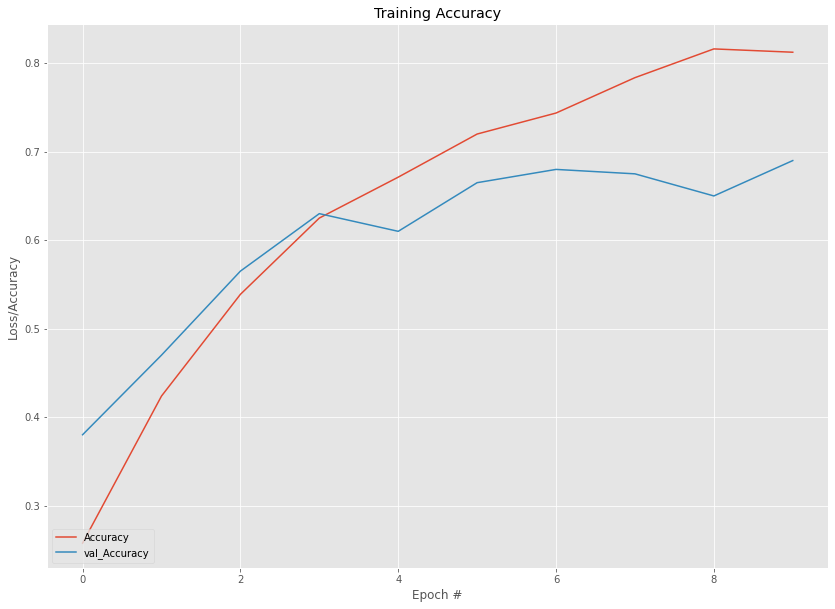

In [91]:
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(14,10))
plt.plot(N, H.history["sparse_categorical_accuracy"], label="Accuracy")
plt.plot(N, H.history["val_sparse_categorical_accuracy"], label="val_Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

# Conclusion

After playing around with the data, and network I kept hitting a plateu of around 62-69% accuracy on the validation data. I ended up adding another layer while increasing the size of the others and ended up being a dense encoder. Training for more than 10 epochs resulted in a larger divergence in training and validation so I kept it at 10 to avoid overfitting. While I didn't reach the 80% goal with this, I believe I may have exausted this method of averaging frames for the data. Just under 70% however is not bad at all and shows that this can be usful and very fast to train.